<a href="https://colab.research.google.com/github/RachelRamirez/FashionMNIST_DataAugmentation/blob/main/Fashion_mnist_convnet_augmentingdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Simple (Fashion) MNIST convnet" Architecture with Extremely Limited Data used to Train CNN

**Original Author with MNIST:** [fchollet](https://twitter.com/fchollet)<br>
Date created: 2015/06/19<br>

**Modified to Fashion MNIST** [rachelramirez](https://github.com/RachelRamirez/FashionMNIST_DataAugmentation) 2021/08/25

**Description:** A simple convnet architecture for training on Fashion MNIST, is frozen and then data augmentation techniques are attempted as a Design of Experiment (DOE).

Then data is limited to varying levels of sample sizes  [500, 1000]  to view the effect of data augmentation on increasing model accuracy.

More features are added to original notebook for residual/error analysis such as confusion matrix and data augmentation.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Sep  1 16:38:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
from google.colab import files
from keras.layers import GaussianNoise


print(tf. __version__) 


2.6.0


# Experiment

The first part of this experiment is looking at the space for *TrainingSize*, *ValidationSize*, *BatchSize*, and *EpochSize*.  These all likely effect one another (4-way interactions) so a DOE design is used to look at Response Surface Methods.

A: BatchSize (10, 100)

B: Epochs  (15, 50)

C: Training Size (Count)  (100, 1000)

D: Validation (as percentage of Training Size)  (20%, 50%) 

Replicates: 2
Center Points: 1

## Prepare the data

In [2]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Until the end of all analysis I don't really want to look at the real test set results
# I'm overwriting them to make sure I don't accidentally use them

x_test = []
y_test = []




# I decide to take a small dataset - 2000 samples of the 60000, and use that to 
# create a TRAIN Set of up to 1000 samples, a VALIDATION Set of up to 1000 samples, and a FAKE-TEST set of the remaining 58000
# After Analyzing the best "Augmentation Effect" I wil apply it to the "REAL" Test DataSet to see if it improved.


# Validation Set is 1000 
x_val = x_train[1000:2000]
y_val = y_train[1000:2000]

#My FAKE Test Set is 58000
x_test = x_train[2000:60000]
y_test = y_train[2000:60000]


# Finally I change train dataset to first 1000
x_train = x_train[0:1000]
y_train = y_train[0:1000]

#My holdout Test Set after all the DOE is the original TEST set from dataset


print("Fashion MNIST has training size up to: ", y_train.shape, ", val set of , ", y_val.shape, " and test set of ", y_test.shape)


# Scale images to the [0, 1] range
#x_train = x_train.astype("float32") / 255
#x_test = x_test.astype("float32") / 255    # put into preprocessing model step
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validation samples")
print(x_test.shape[0], "fake test samples saved from test-set")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Try to put in tensor flow shape
x_val = tf.stack(x_val)
y_val = tf.stack(y_val)


# Define Manual Validation Set
valid_set = (x_val, y_val)


Fashion MNIST has training size up to:  (1000,) , val set of ,  (1000,)  and test set of  (58000,)
x_train shape: (1000, 28, 28, 1)
1000 train samples
1000 validation samples
58000 fake test samples saved from test-set


## DOE Loops with Model Building 

In [3]:
# ## Scratch try first

# factors = "FlipHorizontal", "Rotate", "Contrast", "Noise"

# # for i in string:
# #   print(i)

# from itertools import compress, product

# def combinations(items):
#     return ( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )  


# x = list(combinations(factors))
# x[0]
# x[1]
# len(x)

# # DOE_Factors = ['Noise'] ['Contrast'] ['Contrast', 'Noise'] ['Rotate'] ['Noise', 'Rotate'] ['Contrast', 'Rotate'] ['Contrast', 'Noise', 'Rotate'] ['FlipHorizontal']  ['Noise', 'FlipHorizontal']
# # ['Contrast', 'FlipHorizontal'] ['Contrast', 'Noise', 'FlipHorizontal'] ['FlipHorizontal', 'Rotate'] ['Noise', 'FlipHorizontal', 'Rotate'] ['Contrast', 'FlipHorizontal', 'Rotate'] ['Contrast', 'Noise', 'FlipHorizontal', 'Rotate']

# # for i in DOE_Factors:
# #   print(i)


# # filename = str(i) + ".csv"

# print(filename)

In [4]:
dataAugmentation = True
randseed = 42 


x = layers.experimental.preprocessing.RandomFlip("horizontal", seed = randseed, name = "FlipHorizontal")
y = layers.experimental.preprocessing.RandomRotation(0.5, seed = randseed, name = "Rotate")
z = layers.experimental.preprocessing.RandomContrast(factor=0.5, seed = randseed, name = "Contrast") 
w = layers.GaussianNoise(0.1, name = "GaussianNoise")



data_augmentation = tf.keras.Sequential([
  # layers.experimental.preprocessing.RandomFlip("horizontal", seed = randseed),  # I assume vertical would be very bad
  # layers.experimental.preprocessing.RandomRotation(0.01, seed = randseed),  # I visualized what 5 degrees looked like and it was rough
  # layers.experimental.preprocessing.RandomContrast(factor=0.1, seed = randseed), # I don't really understand this yet
  # layers.GaussianNoise(0.01)
  x,
  y,
  z,
  w, 
])


# datagen  = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.0)

# datagen.fit(x_train)


if dataAugmentation == False:
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dropout(0.5),
          layers.Dense(num_classes, activation="softmax"),
      ]
  )
else:
    model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
          layers.experimental.preprocessing.Rescaling(1./255, input_shape=(input_shape)),
          data_augmentation,   
          layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dropout(0.5),
          layers.Dense(num_classes, activation="softmax"),
      ]
  )
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)             

# Insert DOE Variables -> Train Model

In [5]:
# screen = False

# ## Experiment 1 'Global' Variables
# if screen == True: 
#   var_BatchSize =  50, 50 #  # Just do 50
#   var_Epochs =     70, 70     # Just do 70
#   var_TrainSize = 100, 505, 1000
#   #var_ValPercent = 0.2, 0.3
# else:
#   var_BatchSize =  50, 50   #  # Just do 50
#   var_Epochs =     70, 70    # Just do 70
#   var_TrainSize = 100, 100
#   #var_ValPercent = 0.2, 0.2




## Train the model

In [6]:
counter = 1
scorelist = []


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
## Save Weight is to help Reset the model before Training, very important, otherwise you get better results every run!
model.save_weights('model_clear.h5') 



for t in var_TrainSize:
  new_x_train = x_train[0:t]  
  new_y_train = y_train[0:t]


  for b in var_BatchSize:
    for e in var_Epochs:
      epochs = e


      model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
      model.load_weights('model_clear.h5')

      # Verbose  = 0 after I verified everything was working to improve overall speed
      %%timeit
      model.fit(new_x_train, new_y_train, batch_size=b, epochs=e,  validation_data=valid_set, verbose=0)

      score = model.evaluate(x_test, y_test, verbose=0)
      # print("Test loss:", score[0])
      # print("Test accuracy:", score[1])
      scorelist += [ [counter, b,  e,    t,    score[0], score[1]] ]
      print("Run: ", counter, "", b, e, t,  "Accuracy: ", score[1], " Loss: ", score[0])
      counter=counter+1

#save scorelist as a csv file
if dataAugmentation:
  filename = 'data_augmented.csv'
else:
    filename = "data.csv"

np.savetxt(filename, scorelist, delimiter=',')


This is run 1 :  10 50 100 had accuracy:  0.4966724216938019  test loss:  1.4587044715881348
This is run 2 :  10 70 100 had accuracy:  0.4860517382621765  test loss:  1.4853713512420654
This is run 3 :  25 50 100 had accuracy:  0.5030516982078552  test loss:  1.544907569885254
This is run 4 :  25 70 100 had accuracy:  0.48815518617630005  test loss:  1.4864652156829834
This is run 5 :  50 50 100 had accuracy:  0.434827595949173  test loss:  1.6681740283966064
This is run 6 :  50 70 100 had accuracy:  0.5062068700790405  test loss:  1.5149917602539062
This is run 7 :  100 50 100 had accuracy:  0.4490344822406769  test loss:  1.720348596572876
This is run 8 :  100 70 100 had accuracy:  0.45622414350509644  test loss:  1.6444802284240723
This is run 9 :  10 50 505 had accuracy:  0.5769482851028442  test loss:  1.2317121028900146
This is run 10 :  10 70 505 had accuracy:  0.60712069272995  test loss:  1.140778660774231
This is run 11 :  25 50 505 had accuracy:  0.5579482913017273  test los

In [7]:
#save file to my personal computer so I don't lose it to google colab timeout

#why isn't this working?! :-( 
#files.download('data.csv') 

In [8]:
# batch_size = 50
# epochs = 30

# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.5)

## Evaluate the trained model

In [9]:
          # score = model.evaluate(x_test, y_test, verbose=1)
          # print("Test loss:", score[0])
          # print("Test accuracy:", score[1])

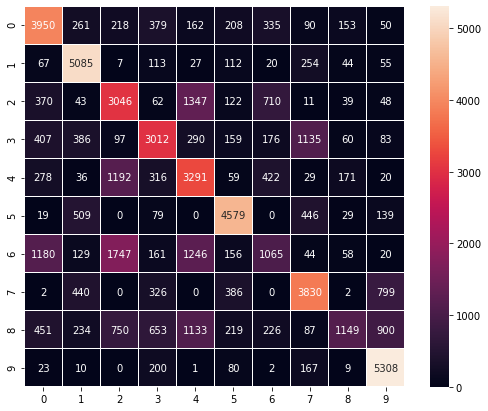

In [10]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
 
y_test = np.argmax(y_test, axis=1) 

confusion_matrix = tf.math.confusion_matrix(y_test, predictions)  #First Variable is on VERTICAL, second Variable is on X HORIZONTAL
#confusion_matrix = tf.math.confusion_matrix(predictions, tf.Variable(np.ones(predictions.shape)))

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()


In my first run, no data augmentation, 100 random samples of the Training Set, using 50% of that as the Validation Set, using a Batch Size of 50 and Epochs = 30, the resulting accuracy of the test-set is Test loss: 0.912209689617157
Test accuracy: 0.6866999864578247

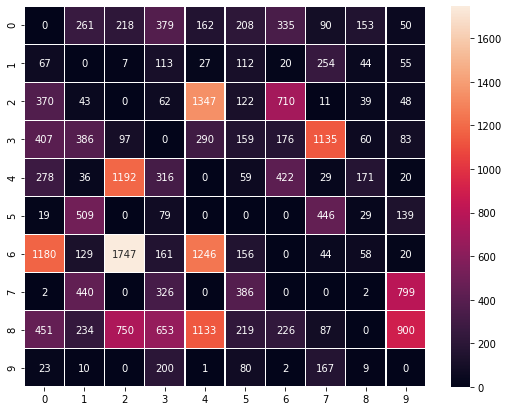

array([6, 5, 6, 8, 2, 7, 2, 3, 4, 8])

array([3, 7, 4, 7, 2, 1, 2, 9, 4, 3])

<tf.Tensor: shape=(), dtype=float64, numpy=23685.0>

In [11]:
## I want to pick the largest value on the confusion matrix not on the diagonal
confusing_part_matrix= np.array(confusion_matrix)-np.identity(confusion_matrix.shape[0])*np.diag(confusion_matrix)

confusing_part_matrix = tf.convert_to_tensor(confusing_part_matrix)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusing_part_matrix,
    annot=True,
    linewidths=.5
    ,fmt='.0f'
    #,fmt="d"
    #,square=True
    #,ax=ax
)
plt.show()


## find the max value of those remaining numbers
thisnumber=np.max(confusing_part_matrix)

x_thisnumber=np.argmax(confusing_part_matrix,axis=0)
y_thisnumber=np.argmax(confusing_part_matrix,axis=1)
z_thisnumber=np.argmax(confusing_part_matrix)
display(x_thisnumber,y_thisnumber)
#print("The worst the algorithm did is between " confus)

display(sum(sum(confusing_part_matrix)))
 

In [12]:
delta = predictions - y_test

wrong = tf.boolean_mask(x_test, delta)

#  if i != 0
#    display("Prediction ", i, " is " + LABEL_NAMES[predictions[i]], "but it is ",  LABEL_NAMES[y_test[i] )


In [13]:
confusing_part_matrix[0]

<tf.Tensor: shape=(10,), dtype=float64, numpy=array([  0., 261., 218., 379., 162., 208., 335.,  90., 153.,  50.])>

In [14]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
z_thisnumber=np.argmax(confusing_part_matrix)
z_thisnumber
print("The algorithm misrecognizes a lot of class " ,  LABEL_NAMES[np.math.floor(z_thisnumber/10)] , " as class ",  LABEL_NAMES[z_thisnumber%10])



The algorithm misrecognizes a lot of class  shirt  as class  pullover


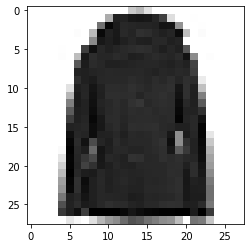

In [15]:
plt.imshow(x_test[0].reshape((28,28)), cmap=plt.cm.binary)
plt.show()

In [15]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')